# Import libraries and modules

In [1]:
%matplotlib inline 

# Libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import time

# Modules
from importlib import reload
from sklearn.externals import joblib
from sklearn.metrics import mean_squared_error

#sys.path.append()

# TFM Github repository
import TFM.feature_engineering as FE
from TFM.settings import set_col_names
from TFM.load_data import load_data
from TFM.sequence_padding import presequence_padding
from TFM.feature_transformation import transform_features
from TFM.build_datasets import build_datasets
from TFM.generate_model import generate_model
from TFM.validation import test_score, get_shuffle_train, get_last_period_result
from TFM.plots import plot_binary_roc_curve, plot_adjustment

Using TensorFlow backend.


# Load data

The functions in **`settings.py`** allow us to define some of the most important variables of the project. By using them, it will not be necessary to specify each of them again in each function where they are needed. These variables are:
+ **Right time-stamp**: It is the right side, not included endpoint of the half open interval of time associated to an observation period. It is also the prediction date of the observation period. It has an indexing role, along with the user ID.
+ **Customer ID**: unique identifier per user (customer in D1). It has an indexing role, along with the right date.
+ **Target**: dependent or objective variable to be predicted by the algorithm. For each observation period, it is computed by considering a finite number (periods to predict) of the user's posterior events. Its type and therefore its computation is different among both experimental datasets.

The **`load_data`** function, in the homonymous file, allow us to load and concatenate the dataframes that contain D1, which are stored as pickles. Its parameters are:
 + cols: columns to load.
 + random_s: size of the sample data.
 
For D1, we randomly select a sample of 100K users for simplicity's sake.

For privacity reasons, we multiply every currency related column by a `secret_number`.

We also fix the type of the categorical features `customer_id` and `last_location_id`, which are loaded as continuous features in the first place.

In [2]:
right_ts = 'fecha_der'
user_id = 'customer_id'
target = 'target_diff'
set_col_names(right_ts=right_ts, user_id=user_id, target=target)

input_path = None
pref = 'drt_'
cols = [
    right_ts, user_id, target, 'frequency', 'money',
    'last_location_id', 'distance', 'last_target', 'birth_year'
]
sample_s = 100000
random_s = 42

In [184]:
%%time

load_df0 = True
name = input_path + 'df0_' + str(sample_s) + '.pkl'

if load_df0:
    df0 = joblib.load(name)

else:
    # load drt pickles
    df0 = load_data(input_path, pref=pref, cols=cols,
                    sample_s=sample_s, random_s=random_s)
    
    # change magnitude for money columns
    for col in [target, 'money', 'last_target']:
        df0[col] = (df0[col]/secret_number).round(2)
    
    # fix categorical columns
    for col in [user_id, 'last_location_id']:
        df0[col] = df0[col].astype(int).astype(str)
    joblib.dump(df0, name, compress=3)

display(df0.head())

,fecha_der,customer_id,target_diff,frequency,money,last_location_id,distance,last_target,birth_year
2487481,2015-01-11 00:00:00+00:00,3,0.0,0.0,0.0,31,4325.373426,0.0,1986.0
2487482,2015-01-18 00:00:00+00:00,3,0.0,0.0,0.0,31,4325.373426,0.0,1986.0
2487483,2015-01-25 00:00:00+00:00,3,0.0,0.0,0.0,31,4325.373426,0.0,1986.0
2487484,2015-02-01 00:00:00+00:00,3,0.0,0.0,0.0,31,4325.373426,0.0,1986.0
2487485,2015-02-08 00:00:00+00:00,3,0.0,0.0,0.0,31,4325.373426,0.0,1986.0


CPU times: user 11 s, sys: 1.78 s, total: 12.7 s
Wall time: 12.8 s


In [16]:
# pd.Series(df0[user_id].drop_duplicates()).to_csv(file_name, index=False, encoding='utf8')

## Pre-sequence padding

+ Deep learning libraries assume a vectorized representation of your data.
+ In the case of variable length sequence prediction problems, this requires that your data be transformed such that each sequence has the same length.
+ This vectorization allows code to efficiently perform the matrix operations in batch for your chosen deep learning algorithms.

**Pre-padding** consists in generating fake empty observation periods before the first one for each user in order to equalize the lengths of all sequences. However, if the sequence lengths are very different from one another, pre-padding all sequence to the largest length would mean to generate a lot of fake observations, which would slow down the model fitting and validation process.

When preprocessing D1, we opted for a middle ground. In the first place, we selected a common factor value (16). Then we applied pre-padding to the period sequences so that the length of every sequence is equal to a number that can be evenly divided by the common factor value. This way, we ended up with 12 different sequence lengths (16, 32...), which is much better than having 182 different values, but we did not generate many fake observations. For those fake observations, we filled the null values in the expense related features with zeros and filled the null values in the user's profile features through a back propagation method per user in case there a non-null posterior value. Fake observations are given a weight equal to zero so that they are not considered as the real ones in the validation process.

The **`presequence_padding`** function transforms data such that each sequence has a length equal to a multiple of a choosen value.

In [5]:
load_df1 = False
name = 'df1_' + str(sample_s) + '.pkl'

if load_df1:
    df1 = joblib.load(name)
else:
    df1 = presequence_padding(df0, 16)
    joblib.dump(df1, name, compress=3)
    
display(df1.head())

Padding sequence lengths...
> Sequence length multiple: 16
> Initial sequence lengths: 182
> Final sequence lengths:   12
> Creating "indexes" (user_id & time-stamp)...
> Merging "indexes" with session data...


,customer_id,fecha_der,target_diff,frequency,money,last_location_id,distance,last_target,birth_year,weight
0,355237,2018-03-18 00:00:00+00:00,0.0,0.0,0.0,17,0.0,0.0,1962.0,1
1,355237,2018-03-25 00:00:00+00:00,0.0,0.0,0.0,17,0.0,0.0,1962.0,1
2,355237,2018-04-01 00:00:00+00:00,0.0,0.0,0.0,17,0.0,0.0,1962.0,1
3,355237,2018-04-08 00:00:00+00:00,0.0,0.0,0.0,17,0.0,0.0,1962.0,1
4,355237,2018-04-15 00:00:00+00:00,0.0,0.0,0.0,17,0.0,0.0,1962.0,1


In [6]:
# sample

for uid in ['375086', '351213']:
    print('user_id = {}'.format(uid))
    print(' > DF0:')
    display(df0.loc[df0[user_id] == uid])
    print(' > DF1:')
    display(df1.loc[df1[user_id] == uid])
    print()

user_id = 375086
 > DF0:


,fecha_der,customer_id,target_diff,frequency,money,last_location_id,distance,last_target,birth_year
1135926,2018-06-10 00:00:00+00:00,375086,21.56,0.0,0.0,66,0.0,0.0,1942.0
1135927,2018-06-17 00:00:00+00:00,375086,27.43,0.0,0.0,66,0.0,0.0,1942.0
1135928,2018-06-24 00:00:00+00:00,375086,29.45,0.0,0.0,66,0.0,0.0,1942.0
1135929,2018-07-01 00:00:00+00:00,375086,36.72,0.0,0.0,66,0.0,0.0,1942.0


 > DF1:


,customer_id,fecha_der,target_diff,frequency,money,last_location_id,distance,last_target,birth_year,weight
91584,375086,2018-03-18 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
91585,375086,2018-03-25 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
91586,375086,2018-04-01 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
91587,375086,2018-04-08 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
91588,375086,2018-04-15 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
91589,375086,2018-04-22 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
91590,375086,2018-04-29 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
91591,375086,2018-05-06 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
91592,375086,2018-05-13 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
91593,375086,2018-05-20 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0



user_id = 351213
 > DF0:


,fecha_der,customer_id,target_diff,frequency,money,last_location_id,distance,last_target,birth_year
3139804,2018-02-25 00:00:00+00:00,351213,20.87,1.0,13.87,42,0.0,13.87,1979.0
3139805,2018-03-04 00:00:00+00:00,351213,-7.80,1.0,14.34,42,0.0,28.21,1979.0
3139806,2018-03-11 00:00:00+00:00,351213,26.00,0.0,0.00,42,0.0,28.21,1979.0
3139807,2018-03-18 00:00:00+00:00,351213,12.45,1.0,17.06,42,0.0,45.26,1979.0
3139808,2018-03-25 00:00:00+00:00,351213,33.82,1.0,3.35,42,0.0,34.74,1979.0
3139809,2018-04-01 00:00:00+00:00,351213,48.15,0.0,0.00,42,0.0,20.40,1979.0
3139810,2018-04-08 00:00:00+00:00,351213,8.90,2.0,33.80,42,0.0,54.21,1979.0
3139811,2018-04-15 00:00:00+00:00,351213,-3.35,1.0,20.56,42,0.0,57.71,1979.0
3139812,2018-04-22 00:00:00+00:00,351213,-13.93,1.0,14.19,42,0.0,68.56,1979.0
3139813,2018-04-29 00:00:00+00:00,351213,7.17,0.0,0.00,42,0.0,68.56,1979.0


 > DF1:


,customer_id,fecha_der,target_diff,frequency,money,last_location_id,distance,last_target,birth_year,weight
260688,351213,2017-11-26 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
260689,351213,2017-12-03 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
260690,351213,2017-12-10 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
260691,351213,2017-12-17 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
260692,351213,2017-12-24 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
260693,351213,2017-12-31 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
260694,351213,2018-01-07 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
260695,351213,2018-01-14 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
260696,351213,2018-01-21 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
260697,351213,2018-01-28 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


# Feature engineering

We apply the following simple feature engineering functions in order to enrich the dataset:
+ `fillna_cols`: Fills null values in a dataframe by using the chosen method.
+ `clip_continuous_f`:  Returns a clipped continuous feature. Alternatively, it returns the lower and upper clip values.
+ `trend_enrichment`: Enriches dataset with global trend data for the chosen continuous feature.

,customer_id,fecha_der,target_diff,frequency,money,last_location_id,distance,last_target,birth_year,weight,prior_target,month,age,money_mean,money_mean_diff
0,355237,2018-03-18 00:00:00+00:00,0.0,0.0,0.0,17,0.0,0.0,1962.0,1,0.0,2.580645,56.0,2.537451,-0.024010
1,355237,2018-03-25 00:00:00+00:00,0.0,0.0,0.0,17,0.0,0.0,1962.0,1,0.0,2.806452,56.0,2.373635,-0.163817
2,355237,2018-04-01 00:00:00+00:00,0.0,0.0,0.0,17,0.0,0.0,1962.0,1,0.0,3.033333,56.0,2.125156,-0.248478
3,355237,2018-04-08 00:00:00+00:00,0.0,0.0,0.0,17,0.0,0.0,1962.0,1,0.0,3.266667,56.0,2.543214,0.418058
4,355237,2018-04-15 00:00:00+00:00,0.0,0.0,0.0,17,0.0,0.0,1962.0,1,0.0,3.500000,56.0,2.616767,0.073552


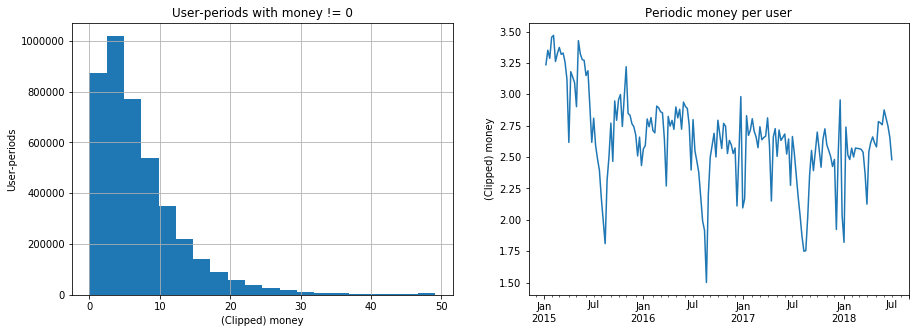

In [7]:
load_df2 = False
name = 'df2_' + str(sample_s) + '.pkl'

if load_df2:
    df2 = joblib.load(name)

else:
    # fill null values
    fillna_val =  {target: 0., 'money': 0., 'last_target': 0., 'frequency': 0.}
    bfill_cols = ['last_location_id', 'distance', 'birth_year']
    df2 = FE.fillna_cols(df1, fillna_val=fillna_val, bfill_cols=bfill_cols)   

    # prior target
    FE.add_prior_target(df2, 4)

    # month
    df2['month'] = FE.get_decimal_month(df2[right_ts])

    # birth_year and age
    m1 = df2['birth_year'] > 2010
    m2 = df2['birth_year'] < 1920
    df2.loc[m1 | m2, 'birth_year'] = np.nan
    df2['age'] = df2[right_ts].dt.year - df2['birth_year']

    # global expense trend
    df2 = FE.trend_enrichment(df2, 'money', q2cu=.999, neg_val=False) 
    
    joblib.dump(df2, name, compress=3)
    
display(df2.head())

In [5]:
if False:
    for uid in ['375086', '351213']:
        print('user_id = {}'.format(uid))
        print(' > DF1:')
        display(df1.loc[df1[user_id] == uid])
        print(' > DF2:')
        display(df2.loc[df2[user_id] == uid])
        print()

# Feature transformation

In [3]:
load_df3 = True
name = 'df3_' + str(sample_s) + '.pkl'
dict_name = 'feat_dict_' + str(sample_s) + '.pkl'

if load_df3:
    df3 = joblib.load(name)
    feat_dict = joblib.load(dict_name)

else:

    con_cols = ['month', 'age', 'distance']

    lstm_cols = {
        'frequency': FE.clip_continuous_f(df2['frequency'], q2cu=.999, neg_val=False, return_lu=True),
        'last_target': FE.clip_continuous_f(df2['last_target'], q2cu=.999, neg_val=False, return_lu=True),
        'prior_target': FE.clip_continuous_f(df2['prior_target'], q2cl=.001, q2cu=.999, return_lu=True),
        'money': FE.clip_continuous_f(df2['money'], q2cu=.999, neg_val=False, return_lu=True),
        'money_mean': (None, None),
        'money_mean_diff': (None, None),
    }

    cat_cols = {'last_location_id': 2}

    df3, feat_dict = FT.transform_features(df2, con_cols=con_cols,
                                           lstm_cols=lstm_cols,
                                           cat_cols=cat_cols)
    
    joblib.dump(df3, name, compress=3)
    joblib.dump(feat_dict, dict_name, compress=3)
    
display(df3.head())

,customer_id,fecha_der,target_diff,birth_year,weight,con__month,con__age,con__distance,con__money,con__money_mean_diff,con__last_target,con__frequency,con__money_mean,con__prior_target,cat__last_location_id
0,355237,2018-03-18 00:00:00+00:00,0.0,1962.0,1,0.212938,0.548387,0.0,0.0,-0.024010,0.0,0.0,2.537451,0.0,7
1,355237,2018-03-25 00:00:00+00:00,0.0,1962.0,1,0.231806,0.548387,0.0,0.0,-0.163817,0.0,0.0,2.373635,0.0,7
2,355237,2018-04-01 00:00:00+00:00,0.0,1962.0,1,0.250764,0.548387,0.0,0.0,-0.248478,0.0,0.0,2.125156,0.0,7
3,355237,2018-04-08 00:00:00+00:00,0.0,1962.0,1,0.270261,0.548387,0.0,0.0,0.418058,0.0,0.0,2.543214,0.0,7
4,355237,2018-04-15 00:00:00+00:00,0.0,1962.0,1,0.289757,0.548387,0.0,0.0,0.073552,0.0,0.0,2.616767,0.0,7


## Build datasets

In [4]:
data_valid, data_test = build_datasets(df3, feat_dict, .85, 4)

> Sequence length: 182 | Train / Validation size: 22229 / 3923 (85.0%)
> Sequence length: 176 | Train / Validation size: 5996 / 1059 (85.0%)
> Sequence length: 160 | Train / Validation size: 6437 / 1136 (85.0%)
> Sequence length: 144 | Train / Validation size: 5310 / 938 (85.0%)
> Sequence length: 128 | Train / Validation size: 7485 / 1321 (85.0%)
> Sequence length: 112 | Train / Validation size: 5370 / 948 (85.0%)
> Sequence length: 96 | Train / Validation size: 5168 / 913 (85.0%)
> Sequence length: 80 | Train / Validation size: 5729 / 1011 (85.0%)
> Sequence length: 64 | Train / Validation size: 5069 / 895 (85.0%)
> Sequence length: 48 | Train / Validation size: 5409 / 955 (85.0%)
> Sequence length: 32 | Train / Validation size: 4703 / 831 (85.0%)
> Sequence length: 16 | Train / Validation size: 6090 / 1075 (85.0%)


## Model definition

In [5]:
models = []

In [6]:
model = generate_model(feat_dict)

________________________________________________________________________________
Layer (type)              Output Shape      Param #  Connected to               
cat_0_input (InputLayer)  (None, None, 1)   0                                   
________________________________________________________________________________
lstm_input (InputLayer)   (None, None, 6)   0                                   
________________________________________________________________________________
cat_0_embedding (Embeddin (None, None, 1, 2 196      cat_0_input[0][0]          
________________________________________________________________________________
lstm_layer_1 (LSTM)       (None, None, 80)  27840    lstm_input[0][0]           
________________________________________________________________________________
cat_0_reshape (Reshape)   (None, None, 2)   0        cat_0_embedding[0][0]      
________________________________________________________________________________
cont_input (InputLayer)   (N

In [7]:
models.append(model)

# Model fitting

In [9]:
%%time

model_i = 0
p2p = 4
epochs = 100
bs = 32

# initialization
z_intra = [[], []]
z_inter = []
nseq = 0 # number of sequences (it is cumulative through epochs)
k = 0
r = np.zeros((100, 2))

model = models[model_i]

for epoch in range(epochs):
    print('Epoch {}:'.format(epoch))
    data = get_shuffle_train(data_test, bs, p2p, noise_factor=.05)
    indexes = list(range(len(data)))
    np.random.shuffle(indexes)

    timing = [0, 0, 0]
    
    for n, i in enumerate(indexes):
        t0 = time.time()
        d = data[i]
        xi = d['X_cat'] + [d['X_con'], d['X_lstm']]
        metrics = model.train_on_batch(xi, d['y'], sample_weight=d['w'])
        ls = d['w'].sum()
        if ls > 0: # always True
            r[k%100, 0] = ls*metrics[0]
            r[k%100, 1] = ls
            k += 1
        
        timing[0] += (time.time() - t0)
        nseq += len(d['y'])
        z_intra[0].append([epoch, bs, nseq] + metrics)
        
        # print 10 times per epoch
        if (n%(len(indexes)//10) == 0):
            t0 = time.time()
            rmse, mae = test_score(model, data_valid)
            mask = r[:, 1] > 0
            rmse_train = np.sqrt(r[mask, 0].sum()/r[mask, 1].sum())
            
            print('   > Seq. {}/{} | Train RMSE = {:.4} | Valid.: RMSE = {:.4}; MAE = {:.4}' \
                  .format(str(n).zfill(4), str(len(indexes)).zfill(4),
                          rmse_train, rmse, mae))

            z_intra[1].append([epoch, bs, nseq, rmse, mae, rmse_train])
            timing[1] += (time.time() - t0)
    
    t0 = time.time()
    rmse_oos, mae_oos = test_score(model, data_valid)
    rmse_oot, mae_oot, y, y_pred = test_score(model, data_test, only_last=True,
                                              return_y=True)

    print()
    print(' > Valid. set (out-of-sample):  RMSE = {:.4}; MAE = {:.4}' \
          .format(rmse_oos, mae_oos))
    print(' > Test set   (out-of-time):    RMSE = {:.4}; MAE = {:.4}' \
          .format(rmse_oot, mae_oot))
    
    z_inter.append([epoch, bs, nseq, rmse_oos, mae_oos, rmse_oot, mae_oot])
    
    timing[2] += (time.time() - t0)
    print(' > Timing: Fit = {} min | E. intra. = {} min | E. epoch = {} min' \
          .format(round(timing[0]/60, 1), round(timing[1]/60, 1), round(timing[2]/60, 1)))
    print()

Epoch 0:
   > Seq. 0000/2656 | Train RMSE = 9.797 | Valid.: RMSE = 10.49; MAE = 5.792
   > Seq. 0265/2656 | Train RMSE = 9.52 | Valid.: RMSE = 9.597; MAE = 5.68
   > Seq. 0530/2656 | Train RMSE = 9.307 | Valid.: RMSE = 9.387; MAE = 5.435
   > Seq. 0795/2656 | Train RMSE = 9.548 | Valid.: RMSE = 9.29; MAE = 5.381
   > Seq. 1060/2656 | Train RMSE = 8.789 | Valid.: RMSE = 9.234; MAE = 5.475
   > Seq. 1325/2656 | Train RMSE = 9.235 | Valid.: RMSE = 9.2; MAE = 5.388
   > Seq. 1590/2656 | Train RMSE = 9.085 | Valid.: RMSE = 9.181; MAE = 5.397
   > Seq. 1855/2656 | Train RMSE = 9.226 | Valid.: RMSE = 9.159; MAE = 5.385
   > Seq. 2120/2656 | Train RMSE = 9.068 | Valid.: RMSE = 9.181; MAE = 5.486
   > Seq. 2385/2656 | Train RMSE = 9.407 | Valid.: RMSE = 9.134; MAE = 5.398
   > Seq. 2650/2656 | Train RMSE = 8.976 | Valid.: RMSE = 9.126; MAE = 5.358

 > Valid. set (out-of-sample):  RMSE = 9.128; MAE = 5.464
 > Test set   (out-of-time):    RMSE = 9.911; MAE = 5.657
 > Timing: Fit = 11.7 min | E. i

   > Seq. 0000/2656 | Train RMSE = 8.696 | Valid.: RMSE = 8.961; MAE = 5.323
   > Seq. 0265/2656 | Train RMSE = 8.905 | Valid.: RMSE = 8.973; MAE = 5.402
   > Seq. 0530/2656 | Train RMSE = 9.379 | Valid.: RMSE = 9.001; MAE = 5.303
   > Seq. 0795/2656 | Train RMSE = 8.826 | Valid.: RMSE = 8.994; MAE = 5.256
   > Seq. 1060/2656 | Train RMSE = 8.858 | Valid.: RMSE = 8.985; MAE = 5.311
   > Seq. 1325/2656 | Train RMSE = 8.808 | Valid.: RMSE = 8.98; MAE = 5.235
   > Seq. 1590/2656 | Train RMSE = 8.932 | Valid.: RMSE = 8.969; MAE = 5.247
   > Seq. 1855/2656 | Train RMSE = 8.884 | Valid.: RMSE = 8.977; MAE = 5.299
   > Seq. 2120/2656 | Train RMSE = 8.676 | Valid.: RMSE = 8.97; MAE = 5.257
   > Seq. 2385/2656 | Train RMSE = 9.251 | Valid.: RMSE = 8.991; MAE = 5.303
   > Seq. 2650/2656 | Train RMSE = 8.916 | Valid.: RMSE = 8.967; MAE = 5.318

 > Valid. set (out-of-sample):  RMSE = 8.982; MAE = 5.283
 > Test set   (out-of-time):    RMSE = 9.669; MAE = 5.384
 > Timing: Fit = 4.4 min | E. intra. =

   > Seq. 0000/2656 | Train RMSE = 8.916 | Valid.: RMSE = 8.927; MAE = 5.237
   > Seq. 0265/2656 | Train RMSE = 8.969 | Valid.: RMSE = 9.023; MAE = 5.391
   > Seq. 0530/2656 | Train RMSE = 8.665 | Valid.: RMSE = 8.931; MAE = 5.292
   > Seq. 0795/2656 | Train RMSE = 8.91 | Valid.: RMSE = 8.965; MAE = 5.232
   > Seq. 1060/2656 | Train RMSE = 8.81 | Valid.: RMSE = 8.97; MAE = 5.294
   > Seq. 1325/2656 | Train RMSE = 9.129 | Valid.: RMSE = 8.933; MAE = 5.232
   > Seq. 1590/2656 | Train RMSE = 8.792 | Valid.: RMSE = 8.93; MAE = 5.208
   > Seq. 1855/2656 | Train RMSE = 9.188 | Valid.: RMSE = 8.947; MAE = 5.227
   > Seq. 2120/2656 | Train RMSE = 8.94 | Valid.: RMSE = 8.928; MAE = 5.285
   > Seq. 2385/2656 | Train RMSE = 9.32 | Valid.: RMSE = 8.934; MAE = 5.281
   > Seq. 2650/2656 | Train RMSE = 8.842 | Valid.: RMSE = 8.931; MAE = 5.266

 > Valid. set (out-of-sample):  RMSE = 8.931; MAE = 5.217
 > Test set   (out-of-time):    RMSE = 9.576; MAE = 5.276
 > Timing: Fit = 4.3 min | E. intra. = 1.7

   > Seq. 0000/2656 | Train RMSE = 8.913 | Valid.: RMSE = 8.914; MAE = 5.234
   > Seq. 0265/2656 | Train RMSE = 8.999 | Valid.: RMSE = 8.917; MAE = 5.261
   > Seq. 0530/2656 | Train RMSE = 8.984 | Valid.: RMSE = 8.912; MAE = 5.319
   > Seq. 0795/2656 | Train RMSE = 8.756 | Valid.: RMSE = 8.927; MAE = 5.283
   > Seq. 1060/2656 | Train RMSE = 8.63 | Valid.: RMSE = 8.905; MAE = 5.245
   > Seq. 1325/2656 | Train RMSE = 8.784 | Valid.: RMSE = 8.923; MAE = 5.185
   > Seq. 1590/2656 | Train RMSE = 8.786 | Valid.: RMSE = 8.908; MAE = 5.318
   > Seq. 1855/2656 | Train RMSE = 8.867 | Valid.: RMSE = 8.908; MAE = 5.237
   > Seq. 2120/2656 | Train RMSE = 8.564 | Valid.: RMSE = 8.929; MAE = 5.335
   > Seq. 2385/2656 | Train RMSE = 8.864 | Valid.: RMSE = 8.914; MAE = 5.262
   > Seq. 2650/2656 | Train RMSE = 9.109 | Valid.: RMSE = 8.918; MAE = 5.285

 > Valid. set (out-of-sample):  RMSE = 8.899; MAE = 5.23
 > Test set   (out-of-time):    RMSE = 9.507; MAE = 5.267
 > Timing: Fit = 4.3 min | E. intra. =

   > Seq. 0000/2656 | Train RMSE = 9.329 | Valid.: RMSE = 8.906; MAE = 5.343
   > Seq. 0265/2656 | Train RMSE = 9.088 | Valid.: RMSE = 8.909; MAE = 5.317
   > Seq. 0530/2656 | Train RMSE = 8.863 | Valid.: RMSE = 8.897; MAE = 5.268
   > Seq. 0795/2656 | Train RMSE = 8.951 | Valid.: RMSE = 8.906; MAE = 5.282
   > Seq. 1060/2656 | Train RMSE = 8.82 | Valid.: RMSE = 8.927; MAE = 5.334
   > Seq. 1325/2656 | Train RMSE = 8.928 | Valid.: RMSE = 8.918; MAE = 5.257
   > Seq. 1590/2656 | Train RMSE = 8.905 | Valid.: RMSE = 8.915; MAE = 5.332
   > Seq. 1855/2656 | Train RMSE = 8.72 | Valid.: RMSE = 8.894; MAE = 5.257
   > Seq. 2120/2656 | Train RMSE = 9.197 | Valid.: RMSE = 8.924; MAE = 5.31
   > Seq. 2385/2656 | Train RMSE = 8.76 | Valid.: RMSE = 8.919; MAE = 5.265
   > Seq. 2650/2656 | Train RMSE = 8.749 | Valid.: RMSE = 8.9; MAE = 5.239

 > Valid. set (out-of-sample):  RMSE = 8.913; MAE = 5.267
 > Test set   (out-of-time):    RMSE = 9.586; MAE = 5.339
 > Timing: Fit = 4.3 min | E. intra. = 1.7

   > Seq. 0000/2656 | Train RMSE = 8.561 | Valid.: RMSE = 8.927; MAE = 5.257
   > Seq. 0265/2656 | Train RMSE = 8.718 | Valid.: RMSE = 8.892; MAE = 5.251
   > Seq. 0530/2656 | Train RMSE = 9.009 | Valid.: RMSE = 8.913; MAE = 5.172
   > Seq. 0795/2656 | Train RMSE = 8.719 | Valid.: RMSE = 8.937; MAE = 5.316
   > Seq. 1060/2656 | Train RMSE = 8.822 | Valid.: RMSE = 8.939; MAE = 5.328
   > Seq. 1325/2656 | Train RMSE = 8.867 | Valid.: RMSE = 8.921; MAE = 5.252
   > Seq. 1590/2656 | Train RMSE = 8.753 | Valid.: RMSE = 8.89; MAE = 5.249
   > Seq. 1855/2656 | Train RMSE = 8.77 | Valid.: RMSE = 8.903; MAE = 5.217
   > Seq. 2120/2656 | Train RMSE = 8.952 | Valid.: RMSE = 8.935; MAE = 5.288
   > Seq. 2385/2656 | Train RMSE = 8.898 | Valid.: RMSE = 8.906; MAE = 5.253
   > Seq. 2650/2656 | Train RMSE = 8.466 | Valid.: RMSE = 8.89; MAE = 5.21

 > Valid. set (out-of-sample):  RMSE = 8.931; MAE = 5.323
 > Test set   (out-of-time):    RMSE = 9.589; MAE = 5.374
 > Timing: Fit = 4.3 min | E. intra. = 1

   > Seq. 0000/2656 | Train RMSE = 8.649 | Valid.: RMSE = 8.904; MAE = 5.287
   > Seq. 0265/2656 | Train RMSE = 8.953 | Valid.: RMSE = 8.94; MAE = 5.397
   > Seq. 0530/2656 | Train RMSE = 8.978 | Valid.: RMSE = 8.888; MAE = 5.208
   > Seq. 0795/2656 | Train RMSE = 8.523 | Valid.: RMSE = 8.9; MAE = 5.239
   > Seq. 1060/2656 | Train RMSE = 8.95 | Valid.: RMSE = 8.932; MAE = 5.277
   > Seq. 1325/2656 | Train RMSE = 9.096 | Valid.: RMSE = 8.897; MAE = 5.259
   > Seq. 1590/2656 | Train RMSE = 8.738 | Valid.: RMSE = 8.911; MAE = 5.246
   > Seq. 1855/2656 | Train RMSE = 8.879 | Valid.: RMSE = 8.911; MAE = 5.313
   > Seq. 2120/2656 | Train RMSE = 8.882 | Valid.: RMSE = 8.912; MAE = 5.26
   > Seq. 2385/2656 | Train RMSE = 8.689 | Valid.: RMSE = 8.947; MAE = 5.252
   > Seq. 2650/2656 | Train RMSE = 9.022 | Valid.: RMSE = 8.92; MAE = 5.311

 > Valid. set (out-of-sample):  RMSE = 8.917; MAE = 5.202
 > Test set   (out-of-time):    RMSE = 9.577; MAE = 5.265
 > Timing: Fit = 4.3 min | E. intra. = 1.7

   > Seq. 0000/2656 | Train RMSE = 8.57 | Valid.: RMSE = 8.888; MAE = 5.319
   > Seq. 0265/2656 | Train RMSE = 9.076 | Valid.: RMSE = 8.886; MAE = 5.225
   > Seq. 0530/2656 | Train RMSE = 8.881 | Valid.: RMSE = 8.907; MAE = 5.187
   > Seq. 0795/2656 | Train RMSE = 8.99 | Valid.: RMSE = 8.889; MAE = 5.188
   > Seq. 1060/2656 | Train RMSE = 8.874 | Valid.: RMSE = 8.878; MAE = 5.192
   > Seq. 1325/2656 | Train RMSE = 8.906 | Valid.: RMSE = 8.876; MAE = 5.211
   > Seq. 1590/2656 | Train RMSE = 8.878 | Valid.: RMSE = 8.892; MAE = 5.248
   > Seq. 1855/2656 | Train RMSE = 8.749 | Valid.: RMSE = 8.91; MAE = 5.232
   > Seq. 2120/2656 | Train RMSE = 8.636 | Valid.: RMSE = 8.877; MAE = 5.23
   > Seq. 2385/2656 | Train RMSE = 8.693 | Valid.: RMSE = 8.886; MAE = 5.223
   > Seq. 2650/2656 | Train RMSE = 8.885 | Valid.: RMSE = 8.893; MAE = 5.256

 > Valid. set (out-of-sample):  RMSE = 8.883; MAE = 5.213
 > Test set   (out-of-time):    RMSE = 9.464; MAE = 5.24
 > Timing: Fit = 4.3 min | E. intra. = 1.

   > Seq. 0000/2656 | Train RMSE = 9.251 | Valid.: RMSE = 8.897; MAE = 5.239
   > Seq. 0265/2656 | Train RMSE = 8.775 | Valid.: RMSE = 8.88; MAE = 5.267
   > Seq. 0530/2656 | Train RMSE = 8.926 | Valid.: RMSE = 8.906; MAE = 5.286
   > Seq. 0795/2656 | Train RMSE = 8.881 | Valid.: RMSE = 8.878; MAE = 5.234
   > Seq. 1060/2656 | Train RMSE = 8.688 | Valid.: RMSE = 8.867; MAE = 5.18
   > Seq. 1325/2656 | Train RMSE = 9.071 | Valid.: RMSE = 8.9; MAE = 5.272
   > Seq. 1590/2656 | Train RMSE = 8.892 | Valid.: RMSE = 8.905; MAE = 5.302
   > Seq. 1855/2656 | Train RMSE = 8.928 | Valid.: RMSE = 8.899; MAE = 5.312
   > Seq. 2120/2656 | Train RMSE = 9.011 | Valid.: RMSE = 8.896; MAE = 5.237
   > Seq. 2385/2656 | Train RMSE = 8.912 | Valid.: RMSE = 8.89; MAE = 5.235
   > Seq. 2650/2656 | Train RMSE = 9.192 | Valid.: RMSE = 8.924; MAE = 5.274

 > Valid. set (out-of-sample):  RMSE = 8.912; MAE = 5.238
 > Test set   (out-of-time):    RMSE = 9.567; MAE = 5.288
 > Timing: Fit = 4.3 min | E. intra. = 1.

   > Seq. 0000/2656 | Train RMSE = 9.148 | Valid.: RMSE = 8.885; MAE = 5.259
   > Seq. 0265/2656 | Train RMSE = 8.9 | Valid.: RMSE = 8.866; MAE = 5.199
   > Seq. 0530/2656 | Train RMSE = 8.796 | Valid.: RMSE = 8.884; MAE = 5.291
   > Seq. 0795/2656 | Train RMSE = 8.465 | Valid.: RMSE = 8.856; MAE = 5.252
   > Seq. 1060/2656 | Train RMSE = 8.667 | Valid.: RMSE = 8.872; MAE = 5.24
   > Seq. 1325/2656 | Train RMSE = 8.834 | Valid.: RMSE = 8.884; MAE = 5.279
   > Seq. 1590/2656 | Train RMSE = 8.789 | Valid.: RMSE = 8.884; MAE = 5.242
   > Seq. 1855/2656 | Train RMSE = 8.874 | Valid.: RMSE = 8.864; MAE = 5.192
   > Seq. 2120/2656 | Train RMSE = 8.796 | Valid.: RMSE = 8.893; MAE = 5.202
   > Seq. 2385/2656 | Train RMSE = 8.981 | Valid.: RMSE = 8.917; MAE = 5.389
   > Seq. 2650/2656 | Train RMSE = 8.891 | Valid.: RMSE = 8.868; MAE = 5.183

 > Valid. set (out-of-sample):  RMSE = 8.875; MAE = 5.162
 > Test set   (out-of-time):    RMSE = 9.448; MAE = 5.191
 > Timing: Fit = 4.3 min | E. intra. = 

   > Seq. 0000/2656 | Train RMSE = 8.744 | Valid.: RMSE = 8.868; MAE = 5.195
   > Seq. 0265/2656 | Train RMSE = 8.892 | Valid.: RMSE = 8.887; MAE = 5.265
   > Seq. 0530/2656 | Train RMSE = 8.991 | Valid.: RMSE = 8.929; MAE = 5.39
   > Seq. 0795/2656 | Train RMSE = 8.657 | Valid.: RMSE = 8.885; MAE = 5.286
   > Seq. 1060/2656 | Train RMSE = 8.899 | Valid.: RMSE = 8.861; MAE = 5.207
   > Seq. 1325/2656 | Train RMSE = 8.674 | Valid.: RMSE = 8.881; MAE = 5.279
   > Seq. 1590/2656 | Train RMSE = 8.933 | Valid.: RMSE = 8.851; MAE = 5.22
   > Seq. 1855/2656 | Train RMSE = 8.852 | Valid.: RMSE = 8.92; MAE = 5.25
   > Seq. 2120/2656 | Train RMSE = 8.836 | Valid.: RMSE = 8.867; MAE = 5.248
   > Seq. 2385/2656 | Train RMSE = 8.615 | Valid.: RMSE = 8.866; MAE = 5.208
   > Seq. 2650/2656 | Train RMSE = 8.801 | Valid.: RMSE = 8.871; MAE = 5.259

 > Valid. set (out-of-sample):  RMSE = 8.88; MAE = 5.3
 > Test set   (out-of-time):    RMSE = 9.537; MAE = 5.365
 > Timing: Fit = 4.3 min | E. intra. = 1.7 

   > Seq. 0000/2656 | Train RMSE = 8.846 | Valid.: RMSE = 8.881; MAE = 5.203
   > Seq. 0265/2656 | Train RMSE = 9.152 | Valid.: RMSE = 8.864; MAE = 5.18
   > Seq. 0530/2656 | Train RMSE = 8.826 | Valid.: RMSE = 8.852; MAE = 5.155
   > Seq. 0795/2656 | Train RMSE = 8.987 | Valid.: RMSE = 8.869; MAE = 5.197
   > Seq. 1060/2656 | Train RMSE = 8.56 | Valid.: RMSE = 8.876; MAE = 5.191
   > Seq. 1325/2656 | Train RMSE = 8.823 | Valid.: RMSE = 8.883; MAE = 5.268
   > Seq. 1590/2656 | Train RMSE = 8.958 | Valid.: RMSE = 8.929; MAE = 5.269
   > Seq. 1855/2656 | Train RMSE = 8.741 | Valid.: RMSE = 8.867; MAE = 5.149
   > Seq. 2120/2656 | Train RMSE = 8.857 | Valid.: RMSE = 8.869; MAE = 5.23
   > Seq. 2385/2656 | Train RMSE = 8.818 | Valid.: RMSE = 8.87; MAE = 5.267
   > Seq. 2650/2656 | Train RMSE = 8.866 | Valid.: RMSE = 8.863; MAE = 5.207

 > Valid. set (out-of-sample):  RMSE = 8.852; MAE = 5.233
 > Test set   (out-of-time):    RMSE = 9.482; MAE = 5.284
 > Timing: Fit = 4.3 min | E. intra. = 1

   > Seq. 0000/2656 | Train RMSE = 8.848 | Valid.: RMSE = 8.878; MAE = 5.208
   > Seq. 0265/2656 | Train RMSE = 8.954 | Valid.: RMSE = 8.863; MAE = 5.224
   > Seq. 0530/2656 | Train RMSE = 8.691 | Valid.: RMSE = 8.866; MAE = 5.232
   > Seq. 0795/2656 | Train RMSE = 9.0 | Valid.: RMSE = 8.858; MAE = 5.221
   > Seq. 1060/2656 | Train RMSE = 8.711 | Valid.: RMSE = 8.883; MAE = 5.344
   > Seq. 1325/2656 | Train RMSE = 9.037 | Valid.: RMSE = 8.877; MAE = 5.235
   > Seq. 1590/2656 | Train RMSE = 9.023 | Valid.: RMSE = 8.873; MAE = 5.231
   > Seq. 1855/2656 | Train RMSE = 8.875 | Valid.: RMSE = 8.859; MAE = 5.196
   > Seq. 2120/2656 | Train RMSE = 8.758 | Valid.: RMSE = 8.881; MAE = 5.186
   > Seq. 2385/2656 | Train RMSE = 8.854 | Valid.: RMSE = 8.878; MAE = 5.223
   > Seq. 2650/2656 | Train RMSE = 8.77 | Valid.: RMSE = 8.868; MAE = 5.213

 > Valid. set (out-of-sample):  RMSE = 8.854; MAE = 5.183
 > Test set   (out-of-time):    RMSE = 9.438; MAE = 5.212
 > Timing: Fit = 4.4 min | E. intra. = 

In [253]:
model_name = 'model00'
model.save(model_name + '.h5')

cols = ['epoch', 'bs', 'nseq', 'oos_rmse', 'oos_mae', 'oot_rmse', 'oot_mae']
metric_cols = ['oos_rmse', 'oos_mae', 'oot_rmse', 'oot_mae']

intra0 = pd.DataFrame(z_intra[0], columns=['epoch', 'bs', 'nseq'] + model.metrics_names)
intra0['rmse'] = np.sqrt(intra0['mean_squared_error'])
intra1 = pd.DataFrame(z_intra[1], columns=['epoch', 'bs', 'nseq', 'rmse', 'mae', 'rmse_train'])
inter = pd.DataFrame(np.array(z_inter), columns=cols)
R = pd.DataFrame([y, y_pred], index=['y', 'yp']).T

joblib.dump(intra0, model_name + '_intra0_' + str(sample_s) + '.pkl')
joblib.dump(intra1, model_name + '_intra1_' + str(sample_s) + '.pkl')
joblib.dump(inter, model_name + '_inter_' + str(sample_s) + '.pkl')
joblib.dump(R, model_name + '_test_result_' + str(sample_s) + '.pkl')

['model00_test_result_100000.pkl']

# Model validation

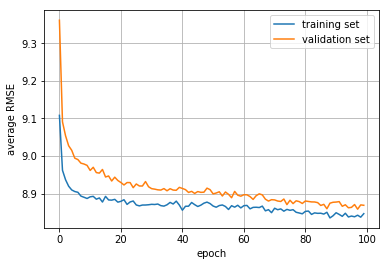

In [343]:
intra0.groupby('epoch')['rmse'].mean().plot()
intra1.groupby('epoch')['rmse'].mean().plot()
plt.legend(['training set', 'validation set'])
plt.grid()
plt.ylabel('average RMSE');

In [318]:
# RNN result
R = (pd.DataFrame([y, y_pred], index=['y', 'yp']).T).sort_values('yp').reset_index(drop=True)
n = 10000
R['group'] = np.floor((R.index)/n).astype(int) + 1
grouped_R = R.groupby('group').mean()
joblib.dump(R, 'result_df_' + str(sample_s) + '.pkl')
rmse = np.sqrt(mean_squared_error(R['y'], R['yp']))

# Vector-based method VS Recurrent Neural Network

In [ ]:
# XGBoost result
R_xgb = joblib.load('xgb_result.pkl')
R_xgb.rename(columns={'target_diff': 'y', 'ypred': 'yp'}, inplace=True)
grouped_R_xgb = R_xgb.groupby('group').mean()
rmse_xgb = np.sqrt(mean_squared_error(R_xgb['y'], R_xgb['yp']))

/home/aegon/.virtualenvs/lr3/lib/python3.5/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


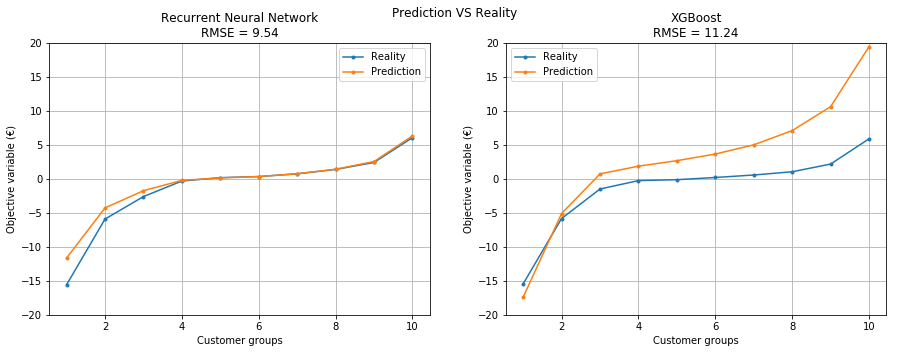

In [327]:
# Plot
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Prediction VS Reality')

ax0 = grouped_R[['y', 'yp']].plot(ax = axs[0], marker='.')
ax0.set_title('Recurrent Neural Network\nRMSE = {}'.format(round(rmse, 2)))
ax0.set_ylim(-20, 20)
ax0.legend(['Reality', 'Prediction'])
ax0.set_xlabel('Customer groups')
ax0.set_ylabel('Objective variable (€)')
ax0.grid()

ax1 = grouped_R_xgb[['y', 'yp']].plot(ax = axs[1], marker='.')
ax1.set_title('XGBoost\nRMSE = {}'.format(round(rmse_xgb, 2)))
ax1.set_ylim(-20, 20)
ax1.legend(['Reality', 'Prediction'])
ax1.set_xlabel('Customer groups')
ax1.set_ylabel('Objective variable (€)')
ax1.grid()

fig.show()